# Loading Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from music21 import converter, instrument, note, chord
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from concurrent.futures import ThreadPoolExecutor
import logging
import pretty_midi
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')


# Functions

In [26]:
# # Function to parse MIDI files and convert them to piano roll representation
# def midi_to_piano_roll(file_path):
#     midi = converter.parse(file_path)
#     parts = instrument.partitionByInstrument(midi)
#     notes = []
#     if parts:  # file has instrument parts
#         for part in parts.parts:
#             if 'Piano' in str(part):  # look for piano part
#                 notes_to_parse = part.recurse()
#                 for element in notes_to_parse:
#                     if isinstance(element, note.Note):
#                         notes.append(str(element.pitch))
#                     elif isinstance(element, chord.Chord):
#                         notes.append('.'.join(str(n) for n in element.normalOrder))
#     else:  # file has notes in flat structure
#         notes_to_parse = midi.flat.notes
#         for element in notes_to_parse:
#             if isinstance(element, note.Note):
#                 notes.append(str(element.pitch))
#             elif isinstance(element, chord.Chord):
#                 notes.append('.'.join(str(n) for n in element.normalOrder))
#     return notes


In [3]:
# Function to parse MIDI files and convert them to piano roll representation
def midi_to_piano_roll(file_path):
    try:
        midi = converter.parse(file_path)
        parts = instrument.partitionByInstrument(midi)
        notes = []
        
        if parts:  # file has instrument parts
            for part in parts.parts:
                if 'Piano' in str(part):  # look for piano part
                    notes_to_parse = part.recurse()
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
        else:  # file has notes in flat structure
            notes_to_parse = midi.flat.notes
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        
        return notes
    
    except Exception as e:
        logging.error(f"Error processing {file_path}: {e}")
        return []

# Loading data with parallel processing

In [4]:
# Function to process a single composer's MIDI files
def process_composer(composer, data_dir):
    midi_files = glob.glob(os.path.join(data_dir, composer, '**', '*.[mM][iI][dD]'), recursive=True)
    notes_list = []
    for file in midi_files:
        notes = midi_to_piano_roll(file)
        notes_list.append(notes)
    return composer, notes_list


In [5]:
# Load and preprocess all MIDI files using parallel processing
def load_data_parallel(data_dir):
    composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
    all_notes = []
    labels = []
    
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_composer, composers, [data_dir]*len(composers))
    
    for composer, notes_list in results:
        all_notes.extend(notes_list)
        labels.extend([composer] * len(notes_list))
    
    return all_notes, labels


In [32]:

# Define directories and parameters
extraction_dir = './data/midiclassics'
data_dir = extraction_dir

# Load and preprocess data using parallel processing
all_notes, labels = load_data_parallel(data_dir)

print(all_notes[0])

[]


# Processing the data

In [7]:
# Convert notes to numeric representation
def prepare_sequences(notes, labels, sequence_length=100):
    pitchnames = sorted(set(item for sublist in notes for item in sublist))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
    network_input = []
    network_output = []
    label_list = []
    
    for note_list, label in zip(notes, labels):
        for i in range(0, len(note_list) - sequence_length):
            seq_in = note_list[i:i + sequence_length]
            seq_out = note_list[i + sequence_length]
            network_input.append([note_to_int[char] for char in seq_in])
            network_output.append(note_to_int[seq_out])
            label_list.append(label)
    
    n_patterns = len(network_input)
    
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(len(pitchnames))
    network_output = tf.keras.utils.to_categorical(network_output)
    
    return network_input, network_output, label_list

sequence_length = 100

# Prepare sequences
network_input, network_output, label_list = prepare_sequences(all_notes, labels, sequence_length)

# Encode labels
label_to_int = {label: i for i, label in enumerate(set(label_list))}
encoded_labels = [label_to_int[label] for label in label_list]
encoded_labels = tf.keras.utils.to_categorical(encoded_labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(network_input, encoded_labels, test_size=0.2, random_state=42)


[0. 0. 0. ... 0. 0. 0.]


# Data analysis

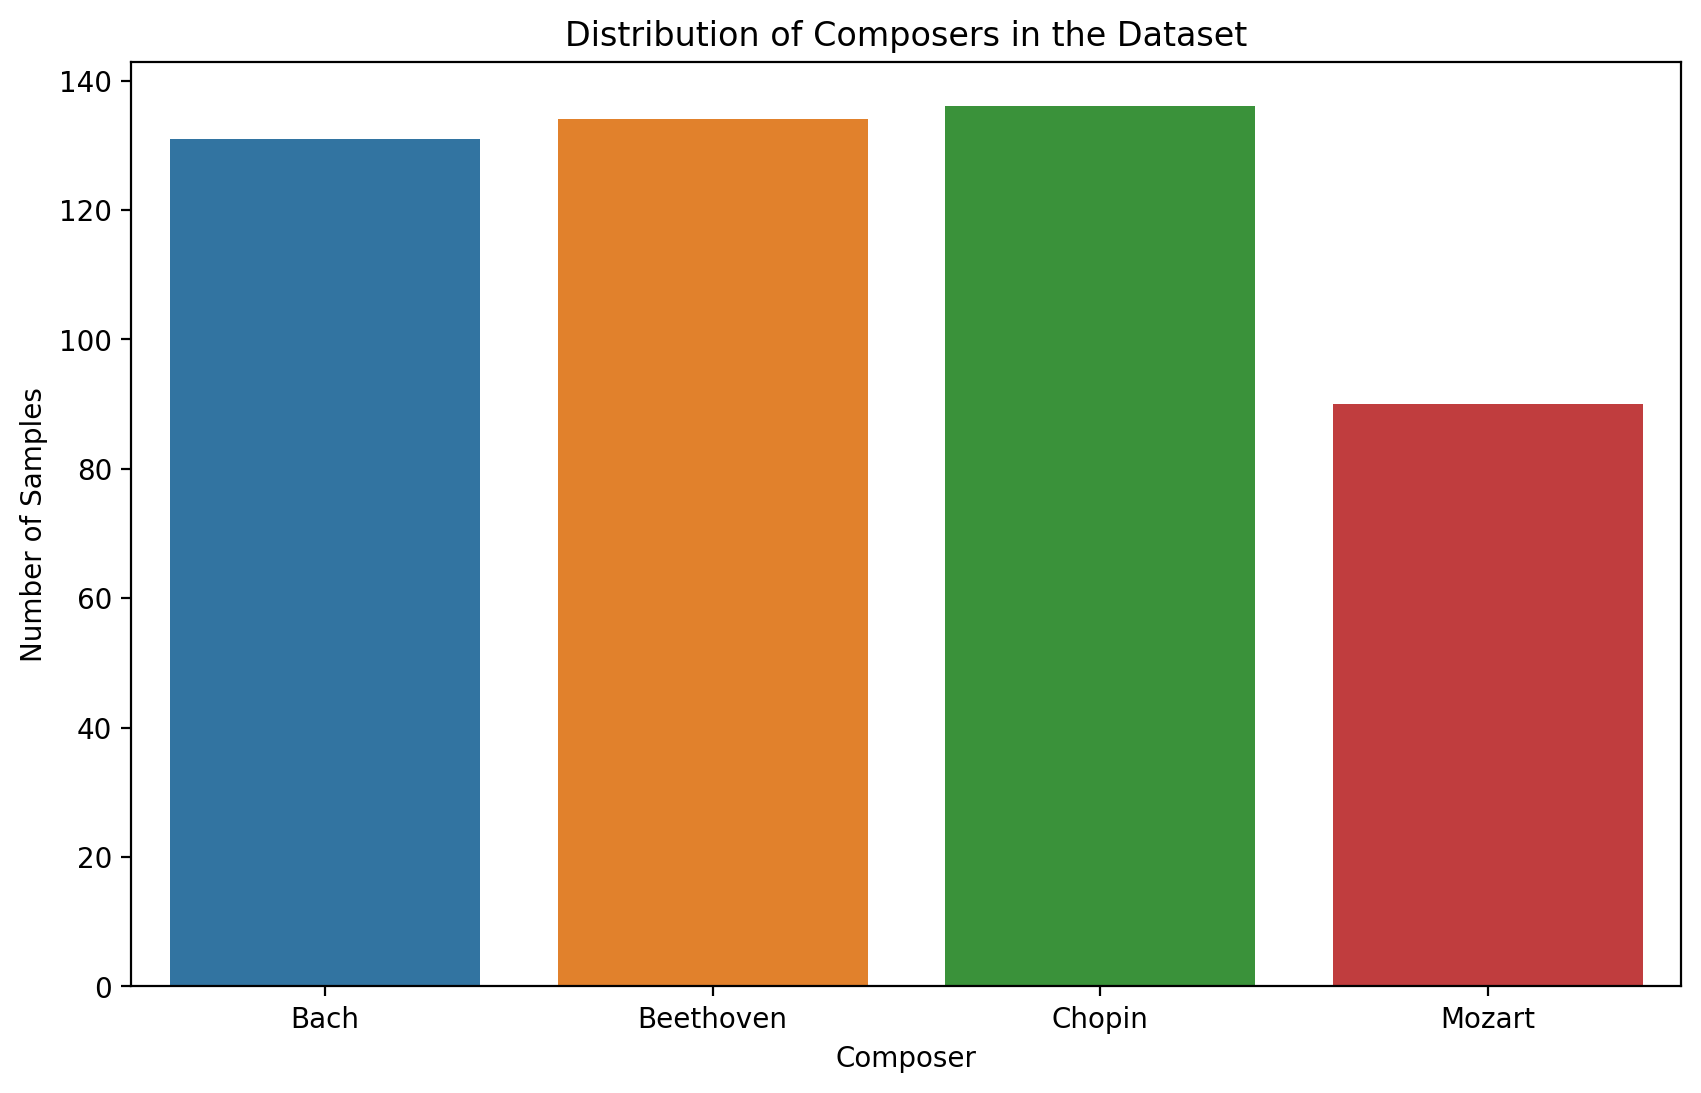

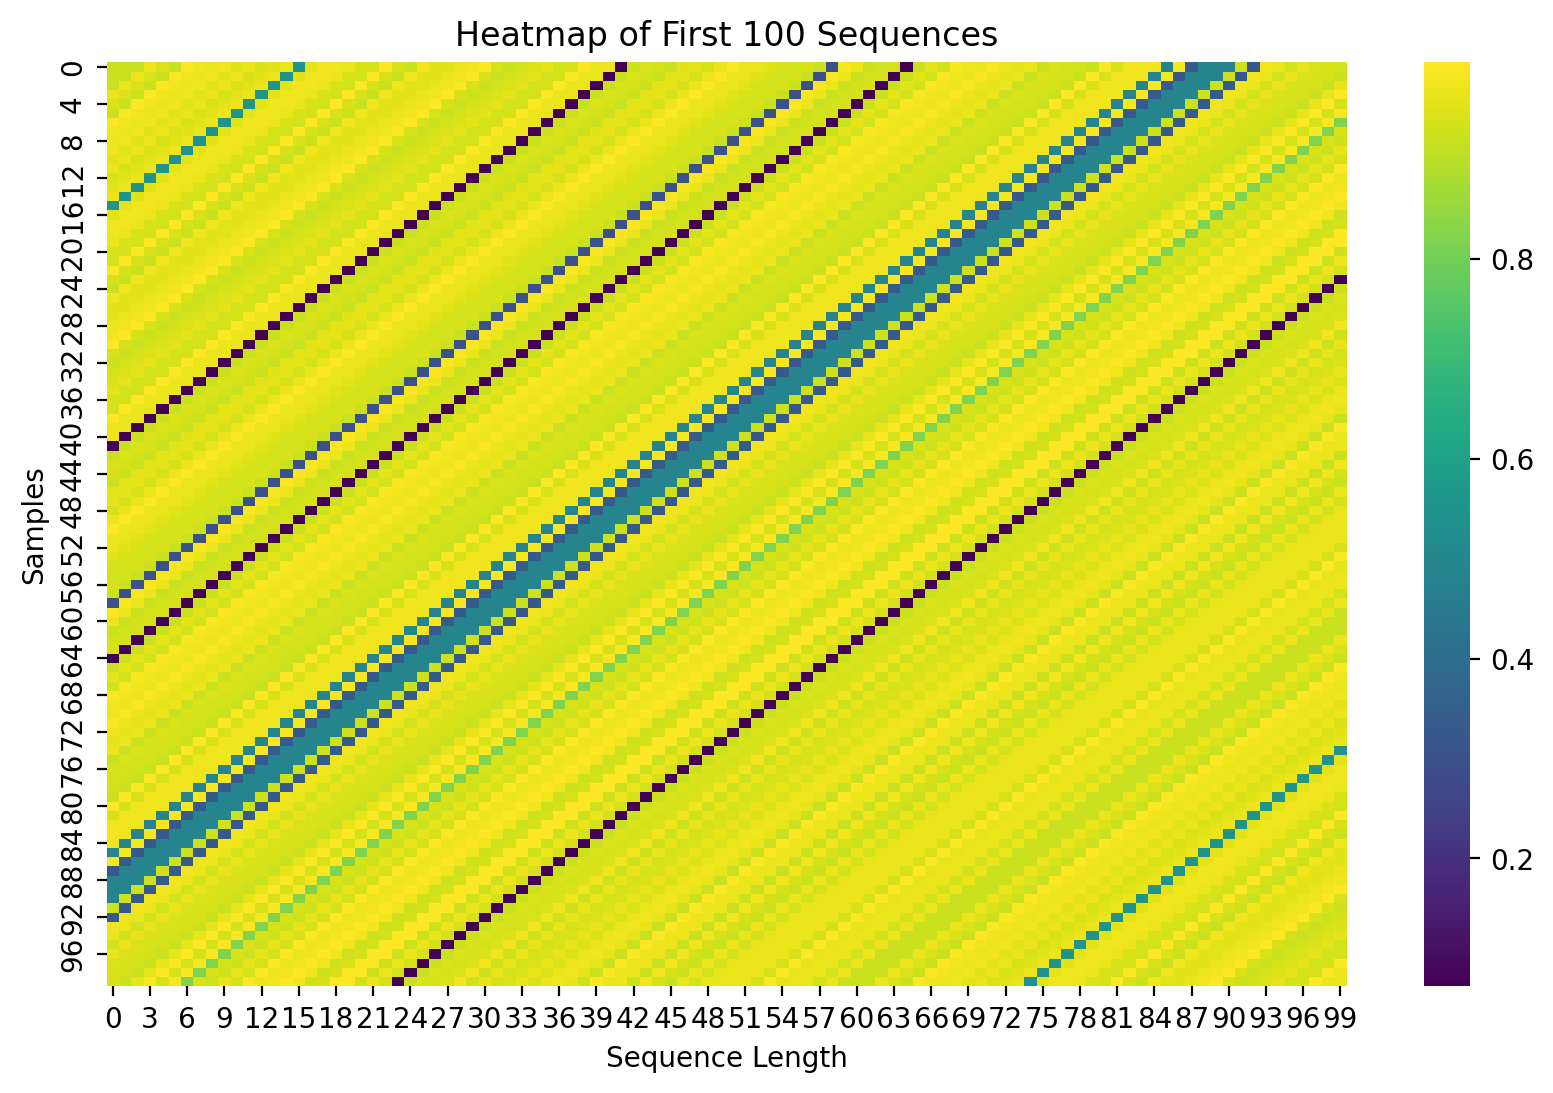

In [11]:
# Extract some basic statistics about the dataset
def dataset_statistics(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    return unique_labels, counts

# Plot the distribution of composers in the dataset
def plot_composer_distribution(unique_labels, counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=counts)
    plt.title('Distribution of Composers in the Dataset')
    plt.xlabel('Composer')
    plt.ylabel('Number of Samples')
    plt.show()

# Plot a heatmap of the first few sequences
def plot_heatmap_sequences(sequences, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(sequences, cmap='viridis')
    plt.title(title)
    plt.xlabel('Sequence Length')
    plt.ylabel('Samples')
    plt.show()

# Get statistics and plot visualizations
unique_labels, counts = dataset_statistics(labels)

# Plot distribution of composers
plot_composer_distribution(unique_labels, counts)

# Plot heatmap of the first few sequences (for example, first 100 sequences)
plot_heatmap_sequences(network_input[:100].reshape(100, sequence_length), 'Heatmap of First 100 Sequences')


# Model architecture and training

In [12]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (sequence_length, 1)
num_classes = len(set(labels))
model = create_cnn_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Save the model
model.save('composer_cnn_model.h5')


Epoch 1/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5129 - loss: 1.1249 - val_accuracy: 0.5973 - val_loss: 0.9597
Epoch 2/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.6128 - loss: 0.9220 - val_accuracy: 0.6517 - val_loss: 0.8321
Epoch 3/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.6919 - loss: 0.7458 - val_accuracy: 0.7140 - val_loss: 0.6987
Epoch 4/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.7501 - loss: 0.6134 - val_accuracy: 0.7451 - val_loss: 0.6344
Epoch 5/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.7952 - loss: 0.5074 - val_accuracy: 0.7736 - val_loss: 0.5609
Epoch 6/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8245 - loss: 0.4344 - val_accuracy: 0.7962 - val_loss: 0.5149
Epoch 7/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.8494 - loss: 0.3720 - val_accuracy: 0.7926 - val_loss: 0.5027
Epoch 8/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8641 - loss: 0

# Model evaluation

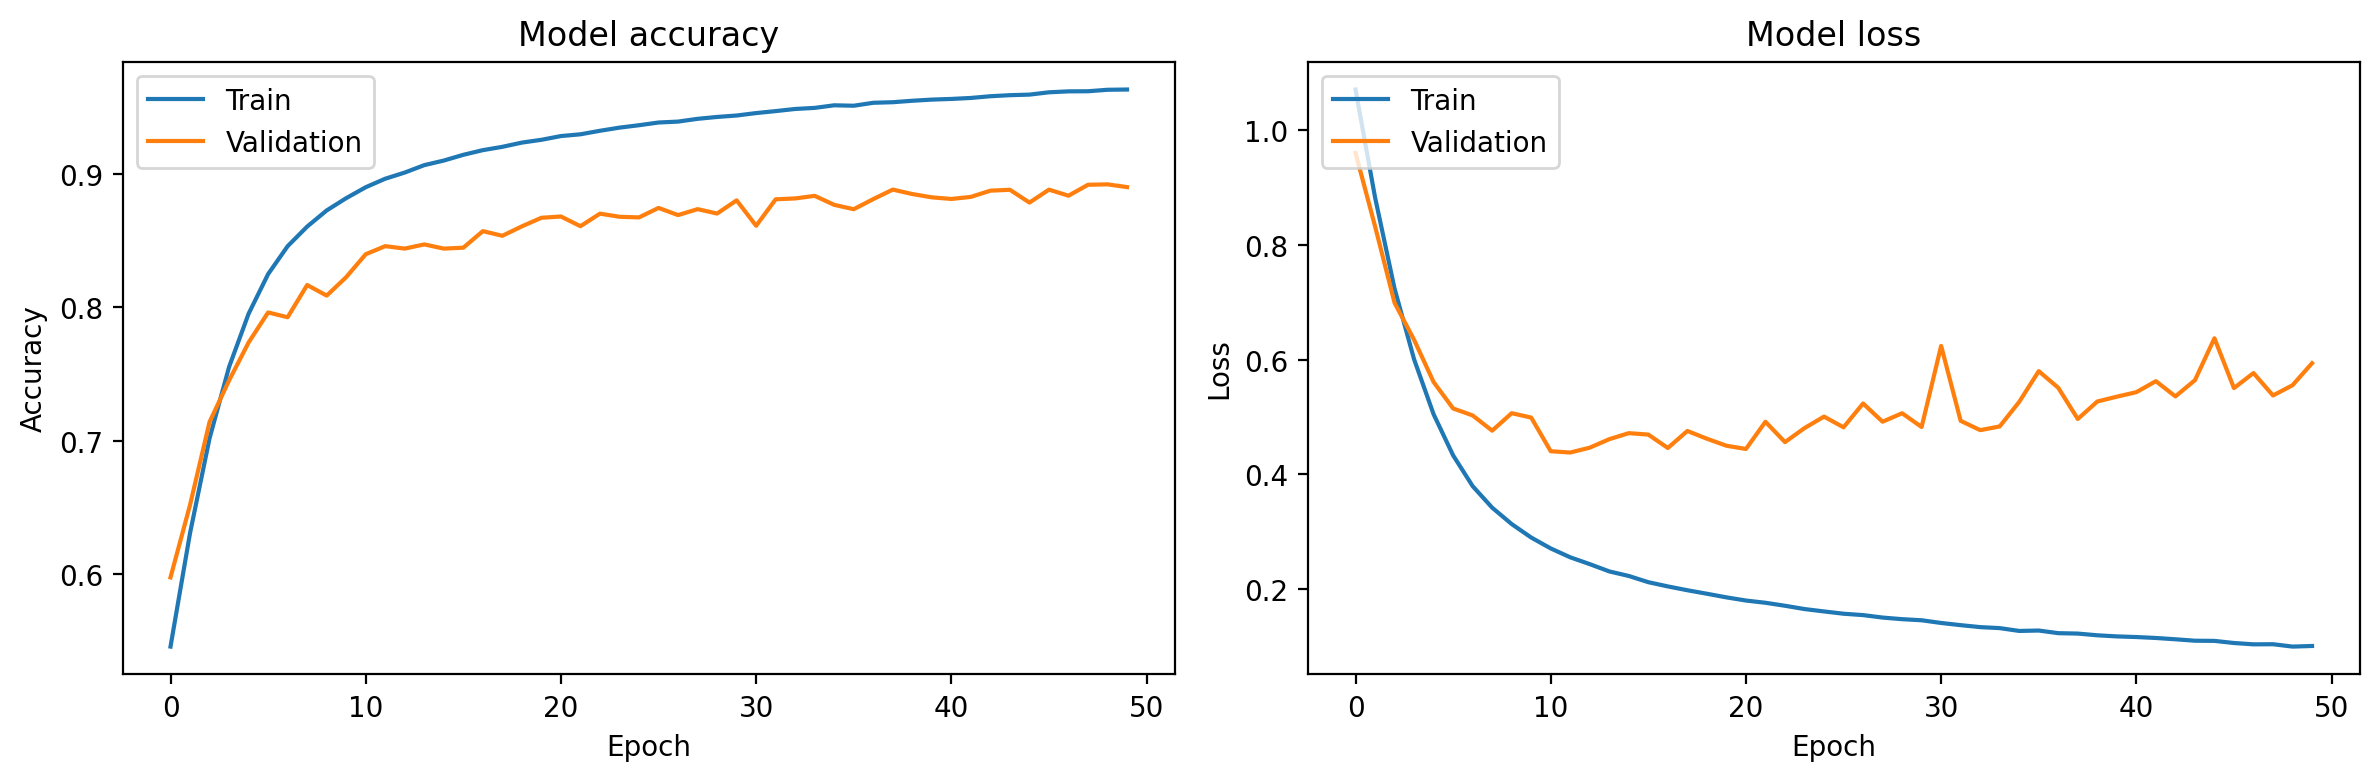

In [13]:
# Evaluate the model
def evaluate_model(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

evaluate_model(history)


# Confusion matrix and classification report

3036/3036 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


<Figure size 1000x1000 with 0 Axes>

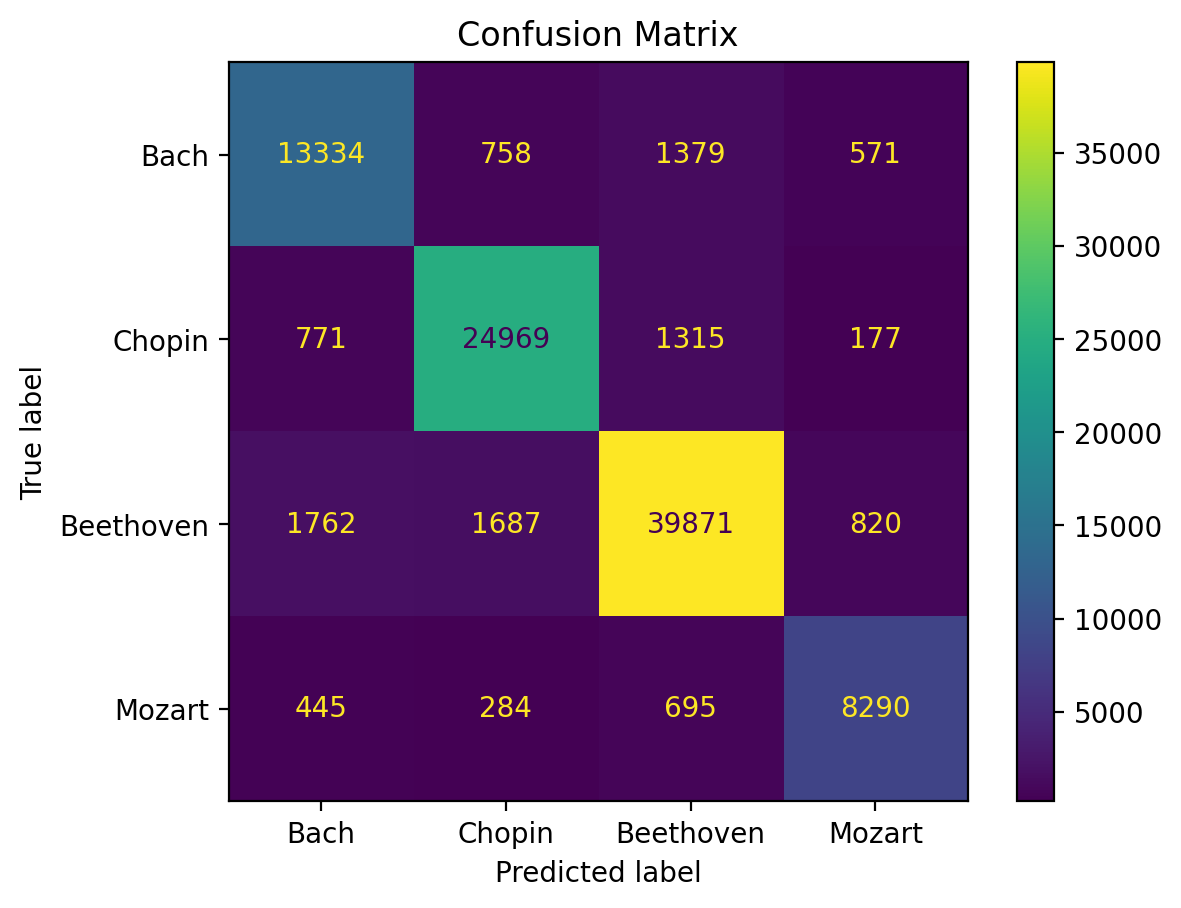

              precision    recall  f1-score   support

        Bach       0.82      0.83      0.82     16042
      Chopin       0.90      0.92      0.91     27232
   Beethoven       0.92      0.90      0.91     44140
      Mozart       0.84      0.85      0.85      9714

    accuracy                           0.89     97128
   macro avg       0.87      0.88      0.87     97128
weighted avg       0.89      0.89      0.89     97128



In [20]:
# Plot confusion matrix and print classification report
def plot_confusion_matrix_and_classification_report(model, X_val, y_val, label_list):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(label_list)))
    
    plt.figure(figsize=(10, 10))
    cm_display.plot(cmap='viridis', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    report = classification_report(y_true, y_pred_classes, target_names=list(set(label_list)))
    print(report)

plot_confusion_matrix_and_classification_report(model, X_val, y_val, label_list)


## LSTM

In [ ]:
# for some reason all notes above kept returning empty after all cells, somewhat duplicative code below

In [27]:
# Populate all_pitches and all_composer
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

all_pitches = []
all_composers = []

extraction_dir = './data/midiclassics'
data_dir = extraction_dir
bach_files = glob.glob(os.path.join(data_dir, 'Bach', '**', '*.[mM][iI][dD]'), recursive=True)

def get_all_pitches_and_composer():
    for composer in composers:
        print(composer)
        composer_files = glob.glob(os.path.join(data_dir, composer, '**', '*.[mM][iI][dD]'), recursive=True)
        for file in composer_files:
            try:
                midi = pretty_midi.PrettyMIDI(file)
                notes = []
                for instrument in midi.instruments:
                    if instrument.is_drum:
                        continue
                    for note in instrument.notes:
                        notes.append(note.pitch)
                if len(notes) > 0:
                    all_pitches.append(notes)
                    all_composers.append(composer)
            except Exception as e:
                logging.error(f"Error processing {file}: {e}")

    
get_all_pitches_and_composer()


Bach
Beethoven


ERROR:root:Error processing ./data/midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Chopin
Mozart


ERROR:root:Error processing ./data/midiclassics\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(all_pitches, all_composers, test_size=0.2, random_state=32, shuffle=True)

In [85]:
# normalize data

min_pitch = min([min(notes) for notes in X_train])
max_pitch = max([max(notes) for notes in X_train])

def normalize_pitch_values(arrays):
    arrays = [np.array(array) for array in arrays]
    normalized_arrays = [(array - min_pitch) / (max_pitch - min_pitch) for array in arrays]
    return normalized_arrays

X_train = normalize_pitch_values(X_train)

In [ ]:
# reshape data

X_train_list = []

for x in X_train:
    # shortest midi is 83, just clamping to here for now
    x = x[:83]
    X_train_list.append(x)

X_train_arr = np.array(X_train_list)

X_train_arr = X_train_arr.reshape(1308, 83, 1)

In [64]:
# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train)

# Convert encoded labels to one-hot vectors
encoded_labels = to_categorical(encoded_labels, num_classes=4)

In [60]:
print(X_train_arr.shape)
# convert y to np array
y_train = np.array(y_train)
print(y_train.shape)


(1308, 83, 1)
(1308,)


In [ ]:
# encode the y labels
label_to_int = {label: i for i, label in enumerate(set(y_train))}
encoded_labels = [label_to_int[label] for label in y_train]
encoded_labels = tf.keras.utils.to_categorical(encoded_labels)

In [66]:
# Build & train the model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(83, input_shape=(83, 1)),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_arr, encoded_labels, epochs=30, batch_size=64)



Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4753 - loss: 1.2913
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6324 - loss: 1.0738
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6253 - loss: 1.0684
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6087 - loss: 1.0980
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6335 - loss: 1.0515
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6388 - loss: 1.0423
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6170 - loss: 1.0725
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6150 - loss: 1.0786
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5996 - loss: 1.1006
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6202 - loss: 1.0655
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6277 - loss: 1.0517
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy:

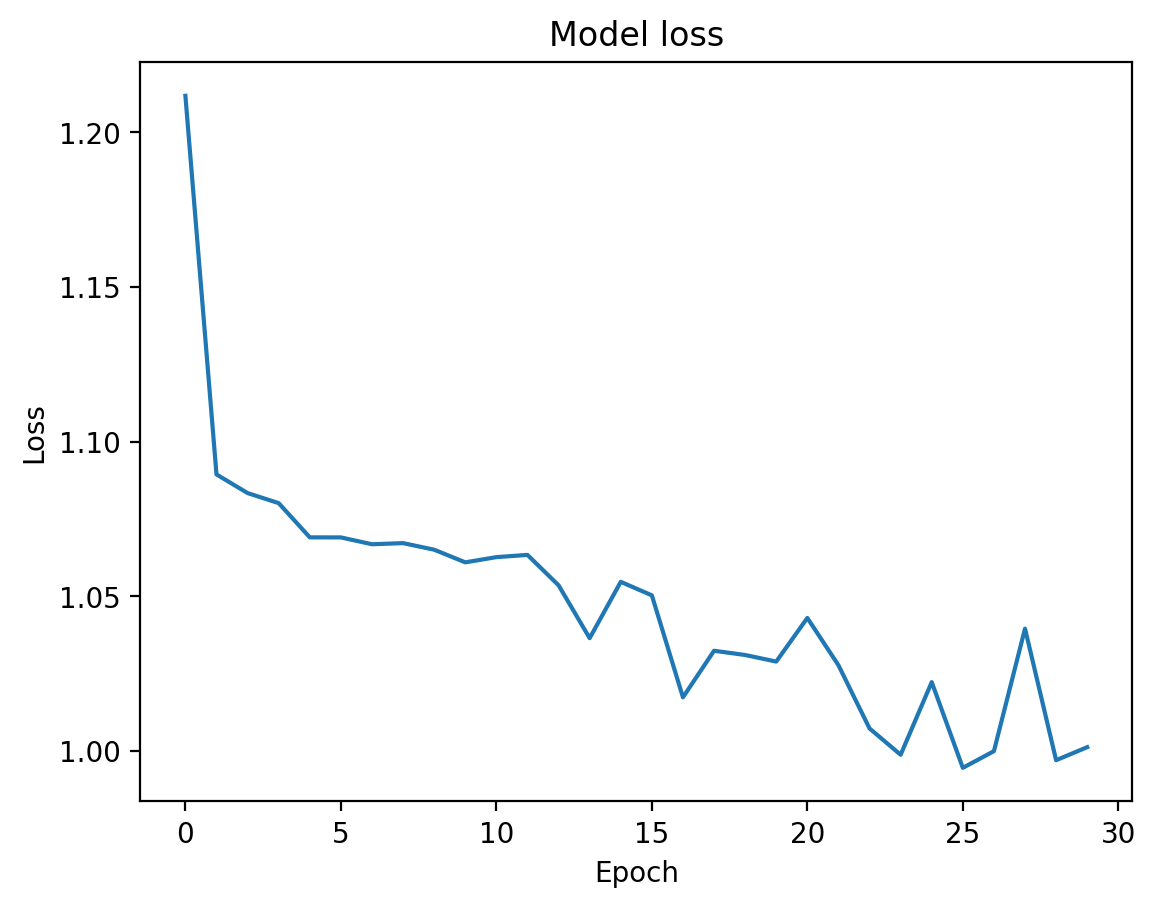

In [67]:
# plot the loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [87]:
# normalize x_test and reshape the data
X_test_normalized = normalize_pitch_values(X_test)

X_test_list = []
for x in X_test_normalized:
    x = x[:83]
    X_test_list.append(x)
X_test_arr = np.array(X_test_list)

327


In [89]:
# encode the y labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_test)
encoded_labels = to_categorical(encoded_labels, num_classes=4)


In [91]:
# create predictions and test accuracy - pretty terrible


predictions = model.predict(X_test_arr)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(encoded_labels, axis=1)
#print classification report
print(classification_report(y_true, y_pred))



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.12      0.88      0.21        43
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        47

    accuracy                           0.12       327
   macro avg       0.03      0.22      0.05       327
weighted avg       0.02      0.12      0.03       327



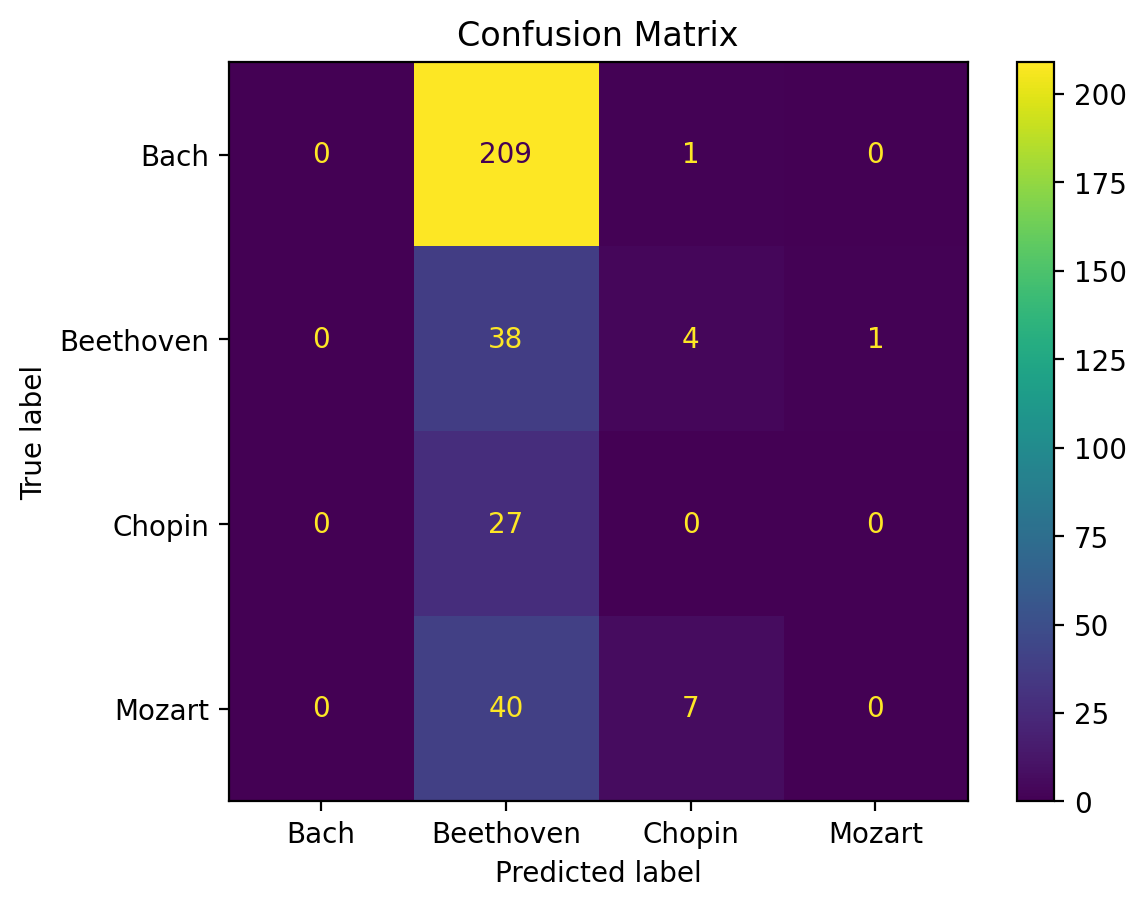

In [97]:

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()


(array([814.,   0.,   0., 176.,   0.,   0., 209.,   0.,   0., 109.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

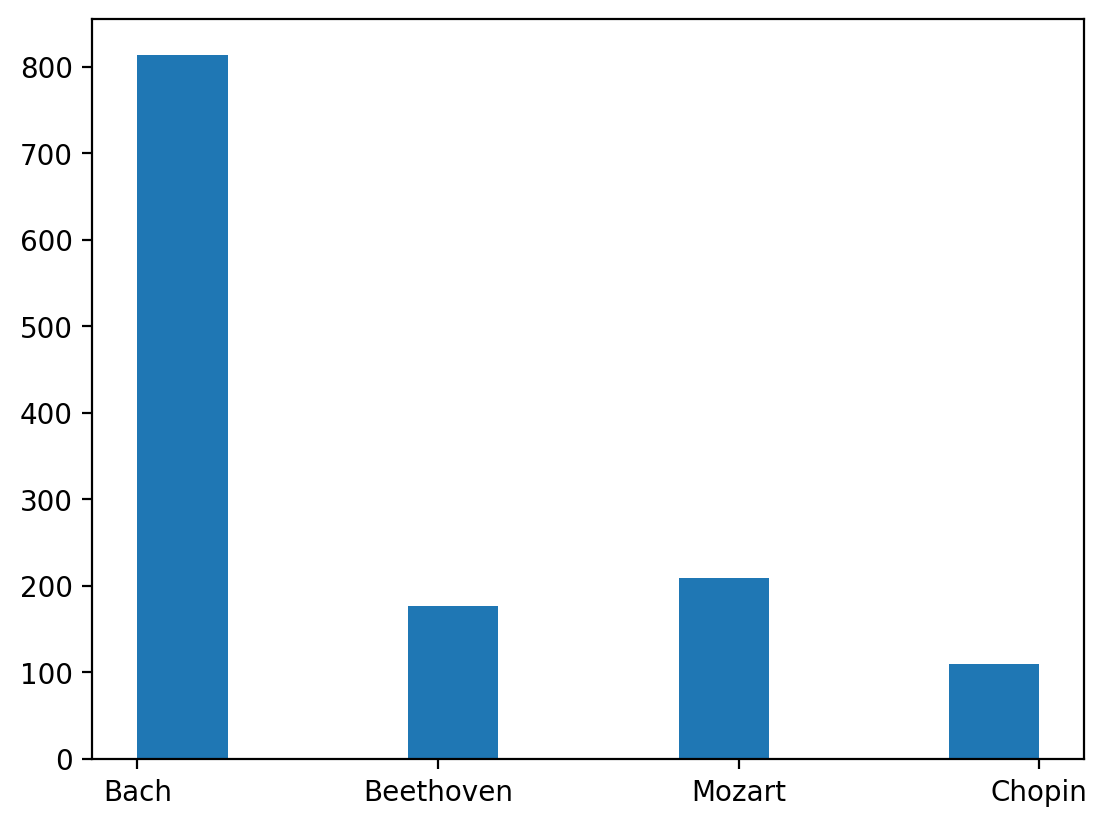

In [99]:
# plot represenation by composter in y of train data
plt.hist(y_train)